In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

In [3]:
train_load = np.load("Utils\\dataset_train.npz")
test_load = np.load("Utils\\dataset_test.npz")

In [4]:
# Get train Data
x_train_path = train_load['x_path']
y_train = train_load['y_train']
y_train_not_encoded = train_load['y_train_raw']

In [5]:
# Get Test Data
x_test_path = test_load['x_path']
y_test = test_load['y_train']
y_test_not_encoded = test_load['y_train_raw']

In [6]:
# Load Required Augmentation
import json

f = open('Utils\\class_require_augment.json')
balance_requirement = json.load(f)
# ['0'] is supposed for label
# ['1'] is supposed for how many times to augment to fulfill balance class

In [7]:
# Check the Ratio
print("Length of train : {}".format(str(y_train.shape[0])))
print("Length of test  : {}".format(str(y_test.shape[0])))

Length of train : 63846
Length of test  : 21281


In [8]:
from Extract.hiragana import basic_hiragana_char
from Extract.katakana import basic_katakana_char

# Make List of Label in One Array
japanese_character = []
japanese_character.extend(basic_hiragana_char)
japanese_character.extend(basic_katakana_char)

In [9]:
# Load Data Test
x_test = []
for idx, path in enumerate(x_test_path):
    img_temp = cv2.imread(path)
    img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
    x_test.append(img_temp)

<h1> Data Augmentation </h1>

In [10]:
# Load image of the train first

x_train = []
for idx, path in enumerate(x_train_path):
    img_temp = cv2.imread(path)
    img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
    x_train.append(img_temp)

タ-ta
Extract//ETL1//IMG_WHITE1\10122_タ-ta_kana.png


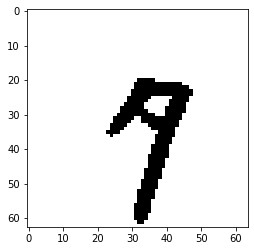

In [46]:
plt.imshow(x_train[100])
print(japanese_character[y_train[100]])
print(x_train_path[100])

In [11]:
from collections import Counter

counter = Counter(np.sort(y_train))
for k, v in counter.items():
    per= v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=271 (0.424%)
Class=1, n=272 (0.426%)
Class=2, n=272 (0.426%)
Class=3, n=271 (0.424%)
Class=4, n=272 (0.426%)
Class=5, n=267 (0.418%)
Class=6, n=271 (0.424%)
Class=7, n=272 (0.426%)
Class=8, n=271 (0.424%)
Class=9, n=271 (0.424%)
Class=10, n=271 (0.424%)
Class=11, n=264 (0.413%)
Class=12, n=271 (0.424%)
Class=13, n=271 (0.424%)
Class=14, n=270 (0.423%)
Class=15, n=271 (0.424%)
Class=16, n=272 (0.426%)
Class=17, n=271 (0.424%)
Class=18, n=272 (0.426%)
Class=19, n=271 (0.424%)
Class=20, n=272 (0.426%)
Class=21, n=271 (0.424%)
Class=22, n=272 (0.426%)
Class=23, n=271 (0.424%)
Class=24, n=272 (0.426%)
Class=25, n=271 (0.424%)
Class=26, n=272 (0.426%)
Class=27, n=271 (0.424%)
Class=28, n=272 (0.426%)
Class=29, n=270 (0.423%)
Class=30, n=271 (0.424%)
Class=31, n=272 (0.426%)
Class=32, n=271 (0.424%)
Class=33, n=272 (0.426%)
Class=34, n=271 (0.424%)
Class=35, n=272 (0.426%)
Class=36, n=271 (0.424%)
Class=37, n=272 (0.426%)
Class=38, n=271 (0.424%)
Class=39, n=272 (0.426%)
Class=40, 

<h4> List Augmented Method </h4>
1. Resize 48 px </br>
2. Resize 36 px </br>
3. Erotion </br>
4. Dilation </br>
5. Brightness

In [12]:
def brightness_settings(img, brightness=255):    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        buf = cv2.addWeighted(img, alpha_b, img, 0, gamma_b)
    else:
        buf = img.copy()
        
    return buf

def morphological_action(img, action):
    kernel = np.ones((1, 1), np.uint8)
    if action == 'dilation':
        return cv2.erode(img, kernel, iterations=1)
    if action == 'erosion':
        return cv2.dilate(img, kernel, iterations=1)
    
def rotation(img, direction='left', degree=45):
    rows, cols = img.shape[0], img.shape[1]
    img_center = (cols / 2, rows / 2)
    
    if direction == 'left':
        rotate_mat = cv2.getRotationMatrix2D(img_center, degree, 1)
    else:
        rotate_mat = cv2.getRotationMatrix2D(img_center, 360-degree, 1)
    
    return cv2.warpAffine(img, rotate_mat, (cols, rows), 
                          borderMode=cv2.BORDER_CONSTANT,
                          borderValue=(255, 255, 255))

In [13]:
# First Augment
# 0. No Augment
# 1. Erosion
# 2. Dilation
# 3. brightness

# Rotation
# 0. No rotation
# 1. Resize 48
# 2. Resize 36

import random

def generate_random_combination(n_combination=2):
    combination = []
    
    itr = 0
    # Looping to generate n combination
    # Only possible for 11 combination, if 11 combination has been fulfilled loop may go infinity
    while itr < n_combination:
        # Generate with range 0f 0-3 and 0-2
        temp = [random.randrange(0, 4), random.randrange(0, 3)]
        
        # Avoid combination [0, 0]
        if temp == [0, 0]:
            continue
        
        # Assign for first iteration
        if itr == 0:
            combination.append(temp)
            itr += 1
        
        # Assign for second and later iteration
        if itr != 0:      
            # Gather Information upwards/backward of array
            isTheSame = False
            for data in combination:
                if data == temp:
                    isTheSame = True
                    break
                    
            # if no similiarity to backward array temp succesfully added
            if isTheSame == False:
                combination.append(temp)
                itr += 1
            else:
                continue

    return np.asarray(combination)

In [14]:
# Lets Augment
augmented_x = []
augmented_y = []
for idx, character in enumerate(japanese_character):
    # Generate Random Combination for augmentation Each Classes
    combination = generate_random_combination(balance_requirement['1'][idx] - 1)

    # Eliminate empty combination(Eg. Class which dont need any augmentation)
    if len(combination) == 0:
        continue
    
    # loop the Combination array
    current_class = idx
    for idx_comb, combinated in enumerate(combination):
        # Loop Through the image
        for idx_img, img in enumerate(x_train):
            if y_train[idx_img] == current_class:
                # Check for the first Augmentation
                temp = img
                if combinated[0] == 1:
                    temp = morphological_action(temp, action='erosion')
                if combinated[0] == 2:
                    temp = morphological_action(temp, action='dilation')
                if combinated[0] == 3:
                    temp = brightness_settings(temp, brightness=50)
                
                if combinated[1] == 1:
                    #temp = rotation(temp, direction='left', degree=45)
                    temp = cv2.resize(temp, (48, 48))
                if combinated[1] == 2:
                    temp = cv2.resize(temp, (36, 36))
                    
                augmented_x.append(temp)
                augmented_y.append(current_class)

In [15]:
len(augmented_y)

132348

<h2> Validating </h2>

80 モ-mo


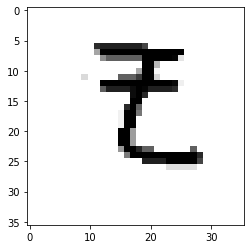

In [16]:
test = augmented_x[120005]
print(augmented_y[120005], japanese_character[augmented_y[120005]])
plt.imshow(test)

10 さ-sa


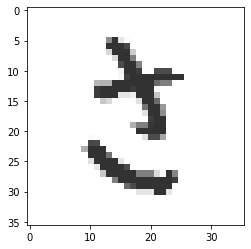

In [17]:
test = augmented_x[20006]
print(augmented_y[20006], japanese_character[augmented_y[20006]])
plt.imshow(test)

<h2> Saving </h2>

In [18]:
y_train = y_train.tolist()

x_train.extend(augmented_x)
y_train.extend(augmented_y)

In [19]:
print(len(x_train), len(y_train))

196194 196194


In [20]:
counter = Counter(np.sort(y_train))
for k, v in counter.items():
    per= v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=2168 (1.105%)
Class=1, n=2176 (1.109%)
Class=2, n=2176 (1.109%)
Class=3, n=2168 (1.105%)
Class=4, n=2176 (1.109%)
Class=5, n=2136 (1.089%)
Class=6, n=2168 (1.105%)
Class=7, n=2176 (1.109%)
Class=8, n=2168 (1.105%)
Class=9, n=2168 (1.105%)
Class=10, n=2168 (1.105%)
Class=11, n=2112 (1.076%)
Class=12, n=2168 (1.105%)
Class=13, n=2168 (1.105%)
Class=14, n=2160 (1.101%)
Class=15, n=2168 (1.105%)
Class=16, n=2176 (1.109%)
Class=17, n=2168 (1.105%)
Class=18, n=2176 (1.109%)
Class=19, n=2168 (1.105%)
Class=20, n=2176 (1.109%)
Class=21, n=2168 (1.105%)
Class=22, n=2176 (1.109%)
Class=23, n=2168 (1.105%)
Class=24, n=2176 (1.109%)
Class=25, n=2168 (1.105%)
Class=26, n=2176 (1.109%)
Class=27, n=2168 (1.105%)
Class=28, n=2176 (1.109%)
Class=29, n=2160 (1.101%)
Class=30, n=2168 (1.105%)
Class=31, n=2176 (1.109%)
Class=32, n=2168 (1.105%)
Class=33, n=2176 (1.109%)
Class=34, n=2168 (1.105%)
Class=35, n=2176 (1.109%)
Class=36, n=2168 (1.105%)
Class=37, n=2176 (1.109%)
Class=38, n=2168 (1.10

In [21]:
import os

In [22]:
# Saving for Train
for idx, img in enumerate(x_train):
    img_format_string = str(idx) + "_" + japanese_character[y_train[idx]] +  "_" + str(y_train[idx]) + "_train_" + ".png"
    saving_string = os.path.join("Dataset", "Train_", img_format_string)
    save2 = os.path.join("obj", img_format_string)
    
    cv2.imwrite(saving_string, img)
    #cv2.imwrite(save2, cv2.resize(img, (64, 64)))

In [23]:
# Saving for test
for idx, img in enumerate(x_test):
    img_format_string = str(idx) + "_" + japanese_character[y_test[idx]] +  "_" + str(y_test[idx]) + "_test_" + ".png"
    saving_string = os.path.join("Dataset", "Test_", img_format_string)
    save2 = os.path.join("obj", img_format_string)
    
    #cv2.imwrite(save2, cv2.resize(img, (64, 64)))
    cv2.imwrite(saving_string, img)

<h2> Testing </h2>

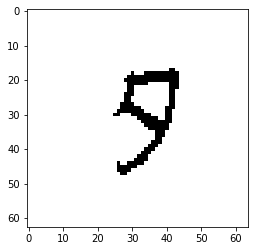

In [25]:
test_img = morphological_action(x_train[1000], action='erosion')
plt.imshow(test_img)